Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Similarity Self-Supervised Learning Hello World

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/similarity/blob/master/examples/supervised_visualization.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/similarity/blob/master/examples/supervised_visualization.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

[TensorFlow Similarity](https://github.com/tensorflow/similarity) is a python package focused on making similarity learning quick and easy. 

### Notebook goal

This notebook demonstrates how to use TensorFlow Similarity to pre-train a `ContrastiveModel()` on the cifar100 dataset.

You are going to learn the main features offered by the `ContrastiveModel()` and will:

1. Create a `SingleShotMemorySampler()` that will generate two augmented views for each example in a batch.

2. Create basic versions of **Backbone**, **Projector**, and **Predictor** networks. These will be used to construct the `ContrastiveModel()`

3. Build a `ContrastiveModel()` using one of the three supported algorithms.

4. Compare the classification performance of training from scratch vs. using the frozen pre-trainined weights.

### Things to try

You can try the following things to improve the model performance:
- Try different self-supervised learning algorithms.
- Use a larger backbone model.
- Use a larger embedding by increasing the size of the projection and predictor layers.
- Try using other augmention functions.

In [1]:
import gc
import os
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [5]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

In [ ]:
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

In [6]:
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.6.0
TensorFlow Similarity 0.15.0.dev51
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Dataset Preperation



In [7]:
data_path = Path("../../kaggle_ds/google_landmarks")

### Loading

In [8]:
((x_raw_train, y_raw_train), (x_test, y_test)), ds_info = tfds.load(
    "cifar100",
    split=["train", "test"],
    batch_size=-1,
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [9]:
print(f"Class Names: {ds_info.features['label'].names}")

Class Names: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', '

Explain why we need to split into query, index, val, and train

In [10]:
# Compute the indicies for query, index, val, and train splits
query_idxs, index_idxs, val_idxs, train_idxs = [], [], [], []
for cid in range(ds_info.features["label"].num_classes):
    idxs = tf.random.shuffle(tf.where(y_raw_train == cid))
    idxs = tf.reshape(idxs, (-1,))
    query_idxs.extend(idxs[:20])  # # 20 query examples per class
    index_idxs.extend(idxs[20:40])  # 20 index examples per class
    val_idxs.extend(idxs[40:60])  # 20 validation examples per class
    train_idxs.extend(idxs[60:])  # The remaining are used for training

random.shuffle(query_idxs)
random.shuffle(index_idxs)
random.shuffle(val_idxs)
random.shuffle(train_idxs)

In [11]:
def create_split(idxs: list) -> tuple:
    x, y = [], []
    for idx in idxs:
        x.append(x_raw_train[int(idx)])
        y.append(y_raw_train[int(idx)])
    return tf.convert_to_tensor(x), tf.convert_to_tensor(y)


x_query, y_query = create_split(query_idxs)
x_index, y_index = create_split(index_idxs)
x_val, y_val = create_split(val_idxs)
x_train, y_train = create_split(train_idxs)

In [12]:
print(
    tabulate(
        [
            ["train", x_train.shape, y_train.shape],
            ["val", x_val.shape, y_val.shape],
            ["test", x_test.shape, y_test.shape],
            ["query", x_query.shape, y_query.shape],
            ["index", x_index.shape, y_index.shape],
        ],
        headers=["Examples", "Labels"],
    )
)

       Examples            Labels
-----  ------------------  --------
train  (44000, 32, 32, 3)  (44000,)
val    (2000, 32, 32, 3)   (2000,)
test   (10000, 32, 32, 3)  (10000,)
query  (2000, 32, 32, 3)   (2000,)
index  (2000, 32, 32, 3)   (2000,)


In [40]:
CIFAR_IMG_SIZE = 32
BATCH_SIZE = 32
INIT_LR = 1e-3
PRE_TRAIN_EPOCHS = 20
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
WARMUP_STEPS = int(PRE_TRAIN_EPOCHS * STEPS_PER_EPOCH * 0.1)
WEIGHT_DECAY = 5e-4
DIM = 256

## Single Shot Sampler

In [14]:
train_augmenter = tfsim.augmenters.SimCLRAugmenter(CIFAR_IMG_SIZE, CIFAR_IMG_SIZE, is_training=True)

@tf.function()
def process(img, cid, num_augmentations_per_example, is_warmup):
    # SimClrAugmenter returns scaled values between [0,1]
    [view1, view2] = train_augmenter(img, cid, num_augmentations_per_example, is_warmup)
    # Effnet expects the inputs between [0, 255]
    return (view1 * 255.0, view2 * 255.0)

In [15]:
train_sampler = tfsim.samplers.SingleShotMemorySampler(
    x_train,
    examples_per_batch=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    augmenter=process,
    num_augmentations_per_example=2,
)

val_sampler = tfsim.samplers.SingleShotMemorySampler(
    x_val,
    examples_per_batch=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    augmenter=process,
    num_augmentations_per_example=2,
)


The initial batch size is 32 (32 classes * 1 examples per class) with 2 augmenters

The initial batch size is 32 (32 classes * 1 examples per class) with 2 augmenters


### Visualize Batching

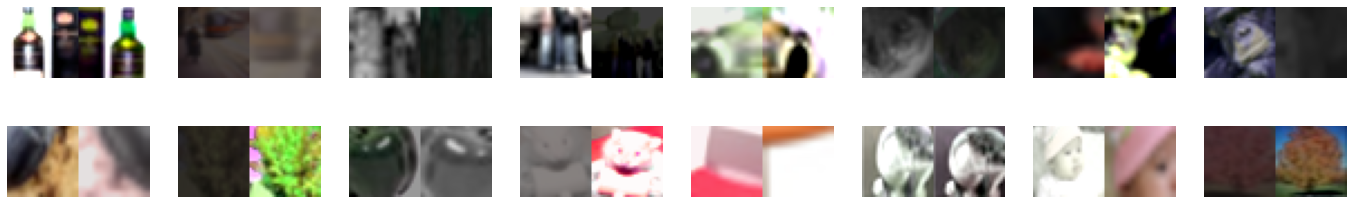

In [16]:
tfsim.visualization.visualize_views(
    views=train_sampler.generate_batch(0), num_imgs=16, views_per_col=8, max_pixel_value=255.0
)

## Models

There are various architectures for building self-supervised models which may include some of the following:
* **Backbone**: This is the base model and is typically an existing architecture like ResNet or EfficientNet.
* **Projector**: This is a small multi-layer Neural Net and provides the embedding features at the end of training.
* **Predictor**: This model is used by BYOL and SimSiam and provides an additional small multi-layer Neural Net.

Typically, the projector and predictor networks are only 2 or 3 layers with batch normalization. Several papers claim that the batch normalization is critical to prevent the model from colapsing to a degenerate solution.

### Backbone Model

Describe why we don't use ImageNet weights

In [17]:
def get_backbone(img_size, dim, activation="relu", trainable=True):
    input_shape = (img_size, img_size, 3)
    backbone = tfsim.architecture.EfficientNetSim(
        input_shape,
        embedding_size=dim,
        variant="B0",
        weights=None, # Don't use ImageNet weights during pretrain.
        augmentation=tf.keras.layers.Resizing(224, 224),
        trainable="full",
        gem_p=3.0,
        l2_norm=False,
    )
    return backbone


backbone = get_backbone(CIFAR_IMG_SIZE, DIM)
backbone.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
generalized_mean_pooling2d ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
Total params: 4,377,507
Trainable params: 4,335,484
Non-trainable params: 42,023
_________________________________________________________________


### Projector Model

In [18]:
def get_projector(input_dim, dim, activation="relu"):
    inputs = tf.keras.layers.Input((input_dim,))
    x = inputs

    for i in range(2):
        x = tf.keras.layers.Dense(
            dim,
            use_bias=False,
            name=f"projection_layer_{i}",
            kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY),
        )(x)
        x = tf.keras.layers.BatchNormalization(name=f"batch_normalization_{i}")(x)
        x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_{i}")(
            x
        )
    o = tf.keras.layers.Dense(
        dim,
        use_bias=False,
        name="projection_output",
        kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY),
    )(x)
    projector = tf.keras.Model(inputs, o, name="projector")
    return projector


projector = get_projector(input_dim=256, dim=DIM)
projector.summary()

Model: "projector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
projection_layer_0 (Dense)   (None, 256)               65536     
_________________________________________________________________
batch_normalization_0 (Batch (None, 256)               1024      
_________________________________________________________________
relu_activation_0 (Activatio (None, 256)               0         
_________________________________________________________________
projection_layer_1 (Dense)   (None, 256)               65536     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
relu_activation_1 (Activatio (None, 256)               0 

### Predictor model

In [19]:
def get_predictor(input_dim, hiddin_dim=512, activation="relu"):
    inputs = tf.keras.layers.Input(shape=(input_dim,))
    x = inputs

    x = tf.keras.layers.Dense(
        hiddin_dim,
        activation=activation,
        use_bias=False,
        name="predictor_layer_0",
        kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY),
    )(x)
    x = tf.keras.layers.BatchNormalization(name="batch_normalization_0")(x)
    x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_0")(x)

    o = tf.keras.layers.Dense(input_dim, name="predictor_output")(x)
    projector = tf.keras.Model(inputs, o, name="predictor")
    return projector


predictor = get_predictor(DIM, hiddin_dim=128)
predictor.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
predictor_layer_0 (Dense)    (None, 128)               32768     
_________________________________________________________________
batch_normalization_0 (Batch (None, 128)               512       
_________________________________________________________________
relu_activation_0 (Activatio (None, 128)               0         
_________________________________________________________________
predictor_output (Dense)     (None, 256)               33024     
Total params: 66,304
Trainable params: 66,048
Non-trainable params: 256
_________________________________________________________________


## Self-Supervised Algorithms

In [41]:
ALGORITHM = "barlow" #@param ["barlow", "simsiam", "simclr"]

if ALGORITHM == "barlow":
    loss = tfsim.losses.Barlow(name="barlow")

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm="barlow",
        projector_embedding_layer_name="projection_layer_1",
    )
elif ALGORITHM == "simsiam":
    loss = tfsim.losses.SimSiamLoss(projection_type="cosine_distance", name="simsiam")

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        predictor=predictor, # NOTE: simiam requires predictor model.
        algorithm="simsiam",
        projector_embedding_layer_name="projection_layer_1",
    )
elif ALGORITHM == "simclr":
    loss = tfsim.losses.SimCLRLoss(name="simclr")

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm="simclr",
        projector_embedding_layer_name="projection_layer_1",
    )
else:
    raise ValueError(f"{ALGORITHM} is not supported.")

### Compile

In [42]:
lr_decayed_fn = tfsim.schedules.WarmUpCosine(
    initial_learning_rate=1e-3,
    decay_steps=PRE_TRAIN_EPOCHS * STEPS_PER_EPOCH,
    warmup_steps=WARMUP_STEPS,
    warmup_learning_rate=0.0,
)
sgd = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
contrastive_model.compile(optimizer=sgd, loss=loss, metrics=[tfsim.training_metrics.encoder_std])

### Callbacks

In [43]:
log_dir = data_path / "models_owen" / f"logs/{loss.name}_{time.time()}"
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)
tbc = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=100,
)
tsc = tfsim.callbacks.EvalCallback(
    x_query, y_query, x_index, y_index, metrics=["f1", "precision", "recall"], k=1, tb_logdir=log_dir
)
mcp_train = tf.keras.callbacks.ModelCheckpoint(
    filepath=data_path / "models_owen" / "checkpoints" / f"{loss.name}_{time.time()}",
    monitor="loss",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
)

TensorBoard logging enable in ../../kaggle_ds/google_landmarks/models_owen/logs/barlow_1639182823.695395/index


## Train

In [44]:
history = contrastive_model.fit(
    train_sampler,
    epochs=PRE_TRAIN_EPOCHS,
    validation_data=val_sampler,
    validation_steps=10,
    callbacks=[early_stopping, tbc, tsc, mcp_train],
)

Epoch 1/20
   6/1375 [..............................] - ETA: 13:01 - loss: 117.9903 - encoder_std: 0.0625WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0794s vs `on_train_batch_end` time: 0.3673s). Check your callbacks.


1375/1375 [==============================] - 125s 85ms/step - loss: 124.7460 - encoder_std: 0.0625 - val_loss: 133.5050 - val_encoder_std: 0.0625
f1: 0.0286 - precision: 0.0145 - recall: 1.0000
Epoch 2/20
1375/1375 [==============================] - 112s 82ms/step - loss: 123.3109 - encoder_std: 0.0625 - val_loss: 118.4352 - val_encoder_std: 0.0625
f1: 0.0227 - precision: 0.0115 - recall: 1.0000
Epoch 3/20
1375/1375 [==============================] - 112s 81ms/step - loss: 123.5678 - encoder_std: 0.0625 - val_loss: 120.7287 - val_encoder_std: 0.0624
f1: 0.0373 - precision: 0.0190 - recall: 1.0000
Epoch 4/20
1375/1375 [==============================] - 112s 81ms/step - loss: 122.4427 - encoder_std: 0.0624 - val_loss: 123.7411 - val_encoder_std: 0.0625
f1: 0.0334 - precision: 0.0170 - recall: 1.0000
Epoch 5/20
1375/1375 [==============================] - 112s 81ms/step - loss: 120.9657 - encoder_std: 0.0625 - val_loss: 128.5963 - val_encoder_std: 0.0625
f1: 0.0286 - precision: 0.0145 - r

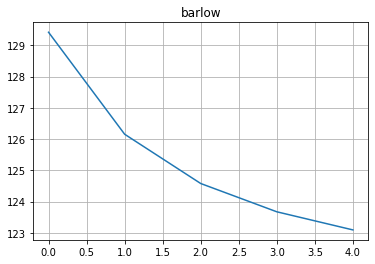

In [38]:
plt.plot(history.history["loss"])
plt.grid()
plt.title(loss.name)
plt.show()

# Evaluation

In [27]:
# allows to use a fraction of the dataset via select_sample
x_restricted, y_restricted = tfsim.samplers.select_examples(
    x_train, y_train, num_examples_per_class=1000
)
y_restricted = tf.keras.utils.to_categorical(y_restricted, 100)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 100)

TEST_EPOCHS = 20
TEST_STEPS_PER_EPOCH = len(x_restricted) // BATCH_SIZE

filtering examples:   0%|          | 0/44000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/100 [00:00<?, ?it/s]

gather examples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [30]:
def get_eval_model(
    img_size,
    backbone,
    projector,
    projector_embedding_layer_name,
    trainable=True,
):
    backbone.trainable = trainable
    embedding = tf.keras.Model(
        projector.input, projector.get_layer(projector_embedding_layer_name).output
    )
    embedding.trainable = trainable
    inputs = tf.keras.layers.Input((img_size, img_size, 3), name="eval_input")
    x = backbone(inputs)
    x = embedding(x)
    o = tf.keras.layers.Dense(100, activation="softmax")(x)
    model = tf.keras.Model(inputs, o, name="no_pretrain")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
    return model

## No Pretrain

In [31]:
no_pt_eval_model = get_eval_model(
    img_size=CIFAR_IMG_SIZE,
    backbone=get_backbone(CIFAR_IMG_SIZE, DIM),
    projector=get_projector(input_dim=256, dim=DIM),
    projector_embedding_layer_name="projection_layer_1",
)
no_pt_history = no_pt_eval_model.fit(
    x_restricted,
    y_restricted,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    validation_data=(x_test, y_test_one_hot),
)

Epoch 1/20
3125/3125 [==============================] - 675s 214ms/step - loss: 3.9651 - acc: 0.0962 - val_loss: 3.4112 - val_acc: 0.1740
Epoch 2/20
3125/3125 [==============================] - 668s 214ms/step - loss: 2.8270 - acc: 0.2723 - val_loss: 2.7688 - val_acc: 0.2944
Epoch 3/20
3125/3125 [==============================] - 666s 213ms/step - loss: 2.1280 - acc: 0.4267 - val_loss: 2.4431 - val_acc: 0.3793
Epoch 4/20
3125/3125 [==============================] - 666s 213ms/step - loss: 1.5912 - acc: 0.5648 - val_loss: 2.4563 - val_acc: 0.4019
Epoch 5/20
3125/3125 [==============================] - 667s 213ms/step - loss: 1.1919 - acc: 0.6707 - val_loss: 2.7232 - val_acc: 0.4022
Epoch 6/20
3125/3125 [==============================] - 667s 214ms/step - loss: 0.9143 - acc: 0.7503 - val_loss: 2.8215 - val_acc: 0.4145
Epoch 7/20
3125/3125 [==============================] - 667s 214ms/step - loss: 0.7319 - acc: 0.8020 - val_loss: 2.8900 - val_acc: 0.4162
Epoch 8/20
3125/3125 [============

## Pretrained

In [32]:
pt_eval_model = get_eval_model(
    CIFAR_IMG_SIZE,
    contrastive_model.backbone,
    contrastive_model.projector,
    projector_embedding_layer_name="projection_layer_1",
    trainable=False,
)
pt_eval_model.summary()

Model: "no_pretrain"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
eval_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
similarity_model (Similarity (None, 256)               4377507   
_________________________________________________________________
model_3 (Functional)         (None, 256)               132096    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               25700     
Total params: 4,535,303
Trainable params: 25,700
Non-trainable params: 4,509,603
_________________________________________________________________


In [ ]:
pt_history = pt_eval_model.fit(
    x_restricted,
    y_restricted,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    validation_data=(x_test, y_test_one_hot),
)

## Comparison

In [30]:
print("no pretrain", no_pt_eval_model.evaluate(x_test, y_test_one_hot))
print("pretrained", pt_eval_model.evaluate(x_test, y_test_one_hot))

313/313 [==============================] - 11s 35ms/step - loss: 0.8289 - acc: 0.8217
no pretrain [0.8288659453392029, 0.8216999769210815]
313/313 [==============================] - 11s 35ms/step - loss: 1.0317 - acc: 0.7621
pretrained [1.0316975116729736, 0.7620999813079834]
